# Segmentación de imágenes basada en agrupamiento aglutinante

### Incluir bibliotecas

In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from skimage       import data
from skimage.color import rgb2grey

from scipy.stats     import entropy
from scipy.stats     import mannwhitneyu as utest
from multiprocessing import Pool

### Métrica basada en diferencia de desvianción estándar

In [2]:
def metric_m(X,Y,e):
    x = np.abs( X.mean() - Y.mean() )
    return x<e

def metric_std(X,Y,e):
    x = np.abs( X.std() - Y.std() )
    return x<e

def aggl(X,X0,C,C0,e=.5):
    m = metric_m( X,X0, e)
    c = np.min( [C,C0] )
    return c, m

### Ejemplo de una matriz aleatoria $6\times 5$

In [3]:
M, N = 6,5
D    = np.random.randn( M*N ).reshape( M,N )
C    = np.arange( D.size )   .reshape( M,N )
np.random.shuffle(C)

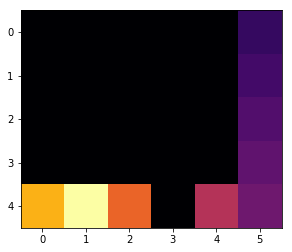

In [4]:
e = .1
for i in range(M-1):
    for j in range(N-1):
        m,c = aggl( D[i,j  ], 
                    D[i,j+1],
                    C[i,j  ], 
                    C[i,j+1], e)
        if m:
            C[i,j  ] = c
            C[i,j+1] = c
        
        m,c = aggl( D[i  ,j], 
                    D[i+1,j],
                    C[i,j  ], 
                    C[i+1,j], e)
        if m:
            C[i  ,j] = c
            C[i+1,j] = c

plt.imshow(C.T,cmap='inferno')

In [13]:
C

array([[ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  4],
       [ 0,  0,  0,  0,  9],
       [ 0,  0,  0,  0, 14],
       [25, 26, 27, 28, 29]])

### Ejemplo con una imagen

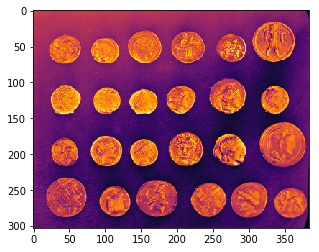

In [31]:
#im = rgb2grey( data.checkerboard() )
im = rgb2grey( data.coins() )
#im = rgb2grey( data.camera() )
im = im/256.
plt.imshow(im,'inferno')

In [32]:
n     = 13
overl = .5
step  = int( overl*n )

x,y = im.shape
x   = np.arange( 0,x-step,step)
y   = np.arange( 0,y-step,step)

x,y = np.meshgrid(x,y)

CPU times: user 966 ms, sys: 99.9 ms, total: 1.07 s
Wall time: 942 ms


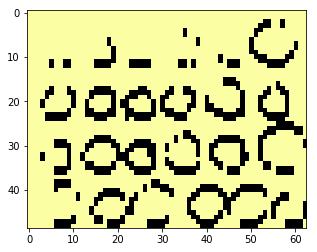

In [35]:
%%time
e = .25
N = x.shape[1]
C = np.arange( x.size ); np.random.shuffle(C)
C = C.reshape( x.shape )
for n,(i,j) in enumerate( zip( x.ravel(),y.ravel() ) ):
    m,c = aggl( im[i:i+step,j     :j  +step], 
                im[i:i+step,j+step:j+2*step],
                C[n/N, n   %N],
                C[n/N,(n+1)%N], e)
    if m:
        C[n/N, n   %N] = c
        C[n/N,(n+1)%N] = c

    m,c = aggl( im[i     :i+  step,j:j+step], 
                im[i+step:i+2*step,j:j+step],
                C[n/N, n   %N],
                C[n/N,(n+1)%N], e)
    if m:
        C[n/N, n   %N] = c
        C[n/N,(n+1)%N] = c
    
plt.imshow(C[:,:-1].T ,cmap='inferno')

In [22]:
C

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

### Histograma como métrica

In [13]:
def Hist(x, bins):
    h = np.histogram( x.ravel(),bins=bins )
    return h[1]

In [11]:
bins = 255

In [14]:
%%time
H = []
for n,(i,j) in enumerate( zip( x.ravel(),y.ravel() ) ):
    h = Hist( im[i:i+step,j:j+step].ravel(),bins ) 
    H.append( h[1] )

CPU times: user 2.14 s, sys: 6.33 ms, total: 2.14 s
Wall time: 2.15 s


In [59]:
%%time
H       = []
pool    = Pool(processes=20)
results = [ pool.apply_async(  Hist, args=(im[i:i+step,j:j+step],bins,) ) 
                                for i,j in zip( x.ravel(),y.ravel() ) ]

H  = [p.get() for p in results]
H  = np.array(H)

CPU times: user 816 ms, sys: 579 ms, total: 1.4 s
Wall time: 1.65 s


In [37]:
H.shape

(3150, 256)

In [61]:
s = x.shape
H = H.reshape( s[0],s[1],H.shape[-1] )

In [39]:
%%time
poolr = Pool(processes=20)
pooll = Pool(processes=20)
R, L   = [], []
for i in range(s[0]-1):
    for j in range(s[1]-1):
        R.append(
          poolr.apply_async(  utest, args=(H[i,j],H[i,j+1],) )
        )
        L.append(
          pooll.apply_async(  utest, args=(H[i,j],H[i+1,j],) )
        )
        

uwr  = [r.get() for r in R]
uwl  = [l.get() for l in L]
uwr  = np.array(uwr)
uwl  = np.array(uwl)

CPU times: user 2.01 s, sys: 891 ms, total: 2.9 s
Wall time: 4.61 s


In [40]:
uwr = uwr.reshape( s[0]-1,s[1]-1,2 )
uwl = uwl.reshape( s[0]-1,s[1]-1,2 )

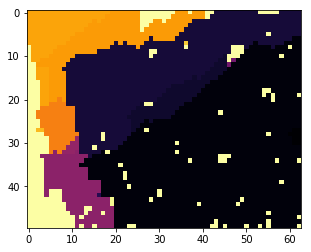

In [74]:
C = np.arange( x.size ); np.random.shuffle(C)
C = C.reshape( x.shape )
e = 0.01
for i in range( uwr.shape[0] ):
    for j in range( uwr.shape[1] ):
        if uwr[i,j,1] < e:
            c        = np.min( [C[i,j],C[i,j+1]] )
            C[i,j  ] = c
            C[i,j+1] = c
        
        if uwl[i,j,1] < e:
            c        = np.min( [C[i,j],C[i+1,j]] )
            C[i  ,j] = c
            C[i+1,j] = c

C[C>50] = 50
plt.imshow(C.T ,cmap='inferno')

In [30]:
set( C.ravel() )

{0, 2, 4, 5, 7, 13, 14, 16, 17, 19, 20, 21, 27, 28, 39, 41, 46, 49, 50}

In [114]:
H.shape

(63, 50, 80)

In [62]:
poolr = Pool(processes=20)
pooll = Pool(processes=20)
R, L  = [], []
for i in range(H.shape[0]-1):
    for j in range(H.shape[1]-1):
        R.append( poolr.apply_async(  entropy,args=(H[i,j],H[i  ,j+1],) ) )
        L.append( pooll.apply_async(  entropy,args=(H[i,j],H[i+1,j  ],) ) )

enr = [r.get() for r in R]
enr = np.array(enr)
enl = [l.get() for l in L]
enl = np.array(enl)

In [63]:
s   = H.shape
enl = enl.reshape( s[0]-1,s[1]-1 )
enr = enr.reshape( s[0]-1,s[1]-1 )

CPU times: user 355 ms, sys: 71 ms, total: 426 ms
Wall time: 355 ms


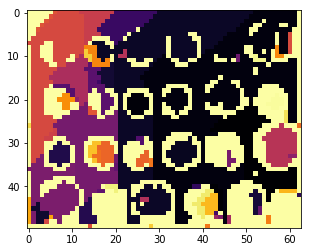

In [64]:
%%time
C = np.arange( x.size ); np.random.shuffle(C)
C = C.reshape( x.shape )
e = .005
for i in range( enr.shape[0]-1 ):
    for j in range( enr.shape[1]-1 ):
        if enr[i,j] < e:
        #if abs( en[i,j]-en[i,j+1] )<e:
            c        = np.min( [C[i,j],C[i,j+1]] )
            C[i,j  ] = c
            C[i,j+1] = c
        
        if enl[i,j] < e:
        #if abs( en[i+1,j]-en[i,j] )<e:
            c        = np.min( [C[i,j],C[i+1,j]] )
            C[i  ,j] = c
            C[i+1,j] = c

#plt.imshow(C.T ,cmap='inferno')
C[C>120] = 120
plt.imshow(C.T ,cmap='inferno')

In [55]:
set(C.ravel())

{0,
 8,
 14,
 15,
 19,
 56,
 64,
 77,
 92,
 157,
 168,
 184,
 188,
 191,
 220,
 238,
 245,
 280,
 402,
 451,
 453,
 456,
 458,
 478,
 485,
 499,
 532,
 542,
 606,
 674,
 705,
 716,
 721,
 757,
 758,
 790,
 882,
 892,
 932,
 936,
 960,
 999,
 1035,
 1058,
 1063,
 1069,
 1082,
 1092,
 1108,
 1139,
 1150,
 1152,
 1160,
 1248,
 1258,
 1268,
 1276,
 1292,
 1296,
 1332,
 1356,
 1357,
 1358,
 1362,
 1460,
 1465,
 1473,
 1480,
 1487,
 1503,
 1506,
 1525,
 1598,
 1612,
 1625,
 1657,
 1738,
 1761,
 1779,
 1869,
 1874,
 1882,
 1888,
 1901,
 1917,
 1933,
 1939,
 1986,
 1992,
 1998,
 2004,
 2012,
 2026,
 2053,
 2054,
 2098,
 2108,
 2161,
 2203,
 2227,
 2237,
 2245,
 2252,
 2283,
 2304,
 2320,
 2354,
 2357,
 2401,
 2506,
 2534,
 2542,
 2561,
 2566,
 2638,
 2646,
 2652,
 2656,
 2705,
 2724,
 2736,
 2737,
 2783,
 2819,
 2829,
 2836,
 2860,
 2911,
 2912,
 2915,
 2963,
 2972,
 2975,
 3014,
 3015,
 3134}

In [66]:
s = H.shape
H = H.reshape( s[0]*s[1],s[2] )

In [67]:
%%time
pool = Pool(processes=20)
R    = [ pool.apply_async(  entropy,args=(h,) ) for h in H ]

en = [r.get() for r in R]
en = np.array(en)

CPU times: user 759 ms, sys: 848 ms, total: 1.61 s
Wall time: 1.47 s


In [68]:
en = en.reshape(x.shape)

CPU times: user 508 ms, sys: 95.2 ms, total: 603 ms
Wall time: 544 ms


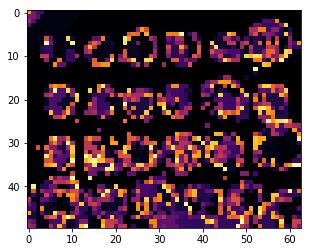

In [71]:
%%time
C = np.arange( x.size ); np.random.shuffle(C)
C = C.reshape( x.shape )
e = .005
for i in range( x.shape[0]-1 ):
    for j in range( x.shape[1]-1 ):
        #if enr[i,j] < e:
        if abs( en[i,j]-en[i,j+1] )<e:
            c        = np.min( [C[i,j],C[i,j+1]] )
            C[i,j  ] = c
            C[i,j+1] = c
        
        #if enl[i,j] < e:
        if abs( en[i+1,j]-en[i,j] )<e:
            c        = np.min( [C[i,j],C[i+1,j]] )
            C[i  ,j] = c
            C[i+1,j] = c

#plt.imshow(C.T ,cmap='inferno')
#C[C>120] = 120
plt.imshow(C.T ,cmap='inferno')

In [70]:
set(C.ravel())

{0, 1, 2, 3, 18, 27, 567, 1087}

In [76]:
from sklearn.metrics.cluster import normalized_mutual_info_score as mis

In [59]:
%%time
H       = []
pool    = Pool(processes=20)
results = [ pool.apply_async(  Hist, args=(im[i:i+step,j:j+step],bins,) ) 
                                for i,j in zip( x.ravel(),y.ravel() ) ]

H  = [p.get() for p in results]
H  = np.array(H)

CPU times: user 816 ms, sys: 579 ms, total: 1.4 s
Wall time: 1.65 s
